In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, \
    max_error, mean_poisson_deviance, mean_gamma_deviance, mean_tweedie_deviance, mean_absolute_percentage_error
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
import optuna
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import backend as K
import lightgbm as lgb
import seaborn as sns
import gc
from prophet import Prophet

In [ ]:
# load all data
df = pd.read_csv('continuous dataset.csv',
                 index_col=[0],
                  parse_dates=[0])

In [ ]:
df

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26 20:00:00,1128.5592,27.246545,0.020303,0.055511,9.289304,25.715295,0.019746,0.121552,1.990773,23.746545,0.018381,0.150879,2.444658,0,0,1
2020-06-26 21:00:00,1112.7488,27.099573,0.020395,0.053848,9.837504,25.552698,0.019632,0.153870,2.094459,23.693323,0.018320,0.156311,2.515814,0,0,1
2020-06-26 22:00:00,1081.5680,26.971155,0.020448,0.057251,10.262464,25.393030,0.019518,0.144531,2.396369,23.658655,0.018327,0.153259,2.800717,0,0,1


<Axes: xlabel='datetime'>

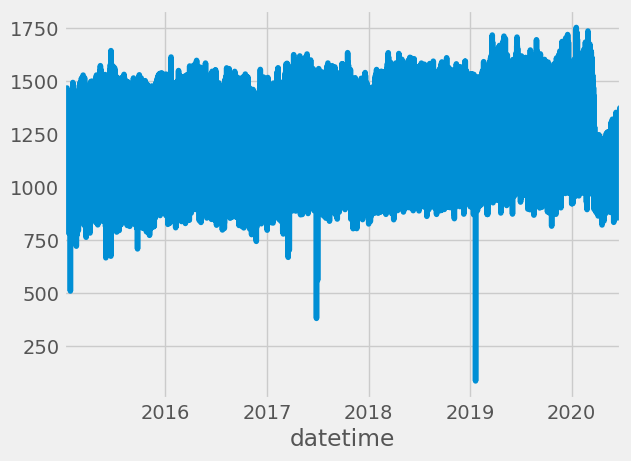

In [ ]:
df["nat_demand"].plot()

In [ ]:
from statistics import mean

print("Max: ",max(df["nat_demand"]))
print("Mean: ",mean(df["nat_demand"]))
print("Min: ",min(df["nat_demand"]))

Max:  1754.882
Mean:  1182.8686472323864
Min:  85.19250000000002


In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    cat_type = pd.CategoricalDtype(categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered=True)
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week  # Calculate week of the year
    df['date_offset'] = (df.date.dt.month * 100 + df.date.dt.day - 320) % 1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
           'dayofyear', 'dayofmonth', 'weekofyear', 'weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X


X, y = create_features(df, label="nat_demand")
features_and_target = pd.concat([X, y], axis=1)

In [ ]:
features_and_target

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,nat_demand
datetime,,,,,,,,,,,
2015-01-03 01:00:00,1,5,1,1,2015,3,3,1,Saturday,Winter,970.3450
2015-01-03 02:00:00,2,5,1,1,2015,3,3,1,Saturday,Winter,912.1755
2015-01-03 03:00:00,3,5,1,1,2015,3,3,1,Saturday,Winter,900.2688
2015-01-03 04:00:00,4,5,1,1,2015,3,3,1,Saturday,Winter,889.9538
2015-01-03 05:00:00,5,5,1,1,2015,3,3,1,Saturday,Winter,893.6865
...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26 20:00:00,20,4,2,6,2020,178,26,26,Friday,Summer,1128.5592
2020-06-26 21:00:00,21,4,2,6,2020,178,26,26,Friday,Summer,1112.7488
2020-06-26 22:00:00,22,4,2,6,2020,178,26,26,Friday,Summer,1081.5680


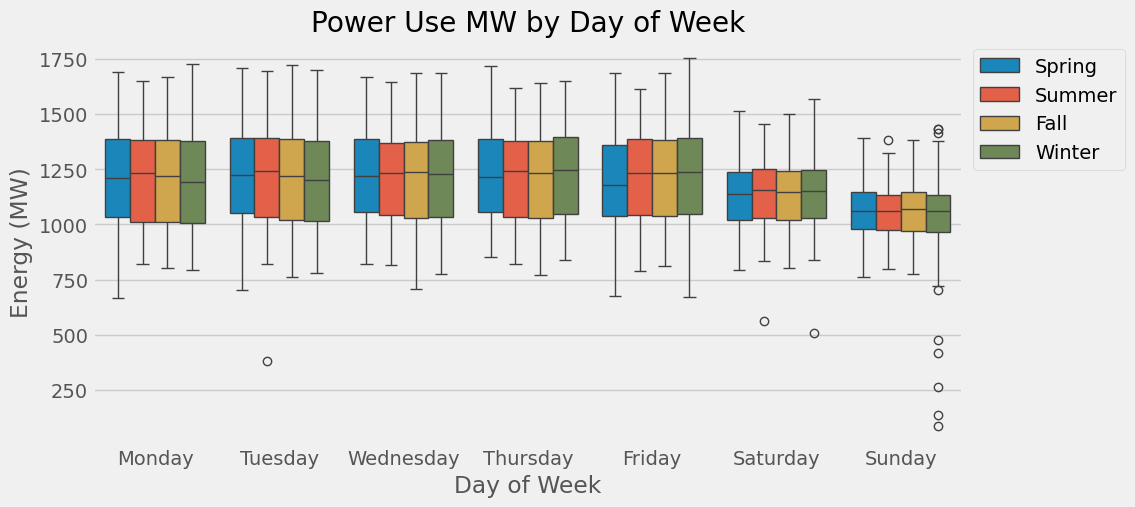

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='nat_demand',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
df1 = pd.read_csv('continuous dataset.csv')
df1

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48043,2020-06-26 20:00:00,1128.5592,27.246545,0.020303,0.055511,9.289304,25.715295,0.019746,0.121552,1.990773,23.746545,0.018381,0.150879,2.444658,0,0,1
48044,2020-06-26 21:00:00,1112.7488,27.099573,0.020395,0.053848,9.837504,25.552698,0.019632,0.153870,2.094459,23.693323,0.018320,0.156311,2.515814,0,0,1
48045,2020-06-26 22:00:00,1081.5680,26.971155,0.020448,0.057251,10.262464,25.393030,0.019518,0.144531,2.396369,23.658655,0.018327,0.153259,2.800717,0,0,1
48046,2020-06-26 23:00:00,1041.6240,26.867487,0.020464,0.064178,10.326567,25.258112,0.019403,0.108063,2.720871,23.601862,0.018358,0.152771,3.138132,0,0,1


In [ ]:
train_df = df1[df1['datetime'] < '2019-01-01']
test_df = df1[df1['datetime'] >= '2019-01-01']

print(f"Shape of train dataset: {train_df.shape}")
print(f"Shape of test dataset: {test_df.shape}")

Shape of train dataset: (35015, 17)
Shape of test dataset: (13033, 17)


In [ ]:
windows = [12, 24, 128]
for column in train_df.columns:
    if column == 'nat_demand':
        for window in windows:
            train_df[f"{column}_lag_{window}"] = train_df[column].shift(window)
            train_df[f"{column}_ma_mean{window}"] = train_df[column].rolling(window).mean()
            train_df[f"{column}_std_std{window}"] = train_df[column].rolling(window).std()
            train_df[f"{column}_ewm_std{window}"] = train_df[column].ewm(window).std()
            train_df[f"{column}_ewm_mean{window}"] = train_df[column].ewm(window).mean()


    if column != 'datetime' and column != 'holiday' and column != 'school' and column != 'Holiday_ID' and column != 'nat_demand':
        for window in windows:
            train_df[f"{column}_lag_{window}"] = train_df[column].shift(window)
            train_df[f"{column}_ma_mean{window}"] = train_df[column].rolling(window).mean()
            train_df[f"{column}_std_std{window}"] = train_df[column].rolling(window).std()
            train_df[f"{column}_ewm_std{window}"] = train_df[column].ewm(window).std()
            train_df[f"{column}_ewm_mean{window}"] = train_df[column].ewm(window).mean()
            train_df[f"{column}_min_max{window}"] = (train_df[column] -train_df[column].rolling(window).min()) / (train_df[column].rolling(window).max() - train_df[column].rolling(window).min())
            train_df[f"{column}_median{window}"] = train_df[column].rolling(window).median()
            train_df[f"{column}_skew{window}"] = train_df[column].rolling(window).skew()
            train_df[f"{column}_kurt{window}"] = train_df[column].rolling(window).kurt()
            train_df[f"{column}_p50{window}"] = train_df[column].rolling(window).quantile(0.5)

In [ ]:
windows = [12, 24, 128]
for column in test_df.columns:
    if column == 'nat_demand':
        for window in windows:

            test_df[f"{column}_lag_{window}"] = test_df[column].shift(window)
            test_df[f"{column}_lag_{window}"] = test_df[column].shift(window)
            test_df[f"{column}_ma_mean{window}"] = test_df[column].rolling(window).mean()
            test_df[f"{column}_std_std{window}"] = test_df[column].rolling(window).std()
            test_df[f"{column}_ewm_std{window}"] = test_df[column].ewm(window).std()
            test_df[f"{column}_ewm_mean{window}"] = test_df[column].ewm(window).mean()

    if column != 'datetime' and column != 'holiday' and column != 'school' and column != 'Holiday_ID' and column != 'nat_demand':
        for window in windows:
            test_df[f"{column}_lag_{window}"] = test_df[column].shift(window)
            test_df[f"{column}_ma_mean{window}"] = test_df[column].rolling(window).mean()
            test_df[f"{column}_std_std{window}"] = test_df[column].rolling(window).std()
            test_df[f"{column}_ewm_std{window}"] = test_df[column].ewm(window).std()
            test_df[f"{column}_ewm_mean{window}"] = test_df[column].ewm(window).mean()
            test_df[f"{column}_min_max{window}"] = (test_df[column] -test_df[column].rolling(window).min()) / (test_df[column].rolling(window).max() - test_df[column].rolling(window).min())
            test_df[f"{column}_median{window}"] = test_df[column].rolling(window).median()
            test_df[f"{column}_skew{window}"] = test_df[column].rolling(window).skew()
            test_df[f"{column}_kurt{window}"] = test_df[column].rolling(window).kurt()
            test_df[f"{column}_p50{window}"] = test_df[column].rolling(window).quantile(0.5)

In [ ]:
train_df.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,...,W2M_dav_lag_128,W2M_dav_ma_mean128,W2M_dav_std_std128,W2M_dav_ewm_std128,W2M_dav_ewm_mean128,W2M_dav_min_max128,W2M_dav_median128,W2M_dav_skew128,W2M_dav_kurt128,W2M_dav_p50128
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,...,NaN,NaN,NaN,NaN,5.364148,NaN,NaN,NaN,NaN,NaN
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,...,NaN,NaN,NaN,0.147307,5.468715,NaN,NaN,NaN,NaN,NaN
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,...,NaN,NaN,NaN,0.254972,5.603917,NaN,NaN,NaN,NaN,NaN
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,...,NaN,NaN,NaN,0.250764,5.674661,NaN,NaN,NaN,NaN,NaN
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,...,NaN,NaN,NaN,0.218585,5.661877,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_df.to_csv('train_df.csv',index=False)
test_df.to_csv('test_df.csv',index=False)

In [ ]:
train_df = pd.read_csv('train_df.csv',
                 index_col=[0],
                  parse_dates=[0])
test_df = pd.read_csv('test_df.csv',
                 index_col=[0],
                  parse_dates=[0])

In [ ]:
train_df.head()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,...,W2M_dav_lag_128,W2M_dav_ma_mean128,W2M_dav_std_std128,W2M_dav_ewm_std128,W2M_dav_ewm_mean128,W2M_dav_min_max128,W2M_dav_median128,W2M_dav_skew128,W2M_dav_kurt128,W2M_dav_p50128
datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,...,NaN,NaN,NaN,NaN,5.364148,NaN,NaN,NaN,NaN,NaN
2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,...,NaN,NaN,NaN,0.147307,5.468715,NaN,NaN,NaN,NaN,NaN
2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,...,NaN,NaN,NaN,0.254972,5.603917,NaN,NaN,NaN,NaN,NaN
2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,...,NaN,NaN,NaN,0.250764,5.674661,NaN,NaN,NaN,NaN,NaN
2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,...,NaN,NaN,NaN,0.218585,5.661877,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(f"Shape of train dataset: {train_df.shape}")
print(f"Shape of test dataset: {test_df.shape}")


Shape of train dataset: (35015, 391)
Shape of test dataset: (13033, 391)


In [ ]:
next_test_df=test_df

In [ ]:
test_df.dropna(inplace=True)
test_df

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,...,W2M_dav_lag_128,W2M_dav_ma_mean128,W2M_dav_std_std128,W2M_dav_ewm_std128,W2M_dav_ewm_mean128,W2M_dav_min_max128,W2M_dav_median128,W2M_dav_skew128,W2M_dav_kurt128,W2M_dav_p50128
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-06 08:00:00,1010.4562,26.479791,0.016606,0.024277,25.745778,25.511041,0.016995,0.017456,11.846568,23.378229,...,6.110409,4.575148,1.511192,1.469350,4.434729,0.584200,4.869911,-0.794132,0.105066,4.869911
2019-01-06 09:00:00,1050.7971,27.411096,0.016399,0.031555,27.262736,27.270471,0.017185,0.014236,14.011013,24.934534,...,6.145190,4.560622,1.504904,1.460425,4.432914,0.540201,4.853817,-0.783848,0.116907,4.853817
2019-01-06 10:00:00,1100.5710,28.260309,0.016414,0.027863,27.282461,28.541559,0.017299,0.011993,14.315570,26.330621,...,6.233335,4.543838,1.498066,1.452007,4.428696,0.507997,4.842220,-0.771877,0.126300,4.842220
2019-01-06 11:00:00,1154.8653,28.903589,0.016452,0.027283,26.760379,29.512964,0.017390,0.011295,14.150185,27.434839,...,6.368042,4.523386,1.490818,1.445092,4.420503,0.454270,4.822929,-0.757241,0.127051,4.822929
2019-01-06 12:00:00,1168.6314,29.288812,0.016428,0.026230,26.304043,30.148187,0.017473,0.012177,13.900855,28.148187,...,6.269188,4.499522,1.487095,1.442391,4.406005,0.368330,4.788671,-0.732426,0.098339,4.788671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26 20:00:00,1128.5592,27.246545,0.020303,0.055511,9.289304,25.715295,0.019746,0.121552,1.990773,23.746545,...,1.519354,2.434515,0.858886,1.080783,2.716574,0.585725,2.437952,-0.269729,-0.461723,2.437952
2020-06-26 21:00:00,1112.7488,27.099573,0.020395,0.053848,9.837504,25.552698,0.019632,0.153870,2.094459,23.693323,...,2.021437,2.438377,0.858125,1.076730,2.715018,0.605266,2.450098,-0.283265,-0.447758,2.450098
2020-06-26 22:00:00,1081.5680,26.971155,0.020448,0.057251,10.262464,25.393030,0.019518,0.144531,2.396369,23.658655,...,2.240761,2.442752,0.858537,1.072575,2.715682,0.683506,2.457710,-0.297688,-0.446453,2.457710


In [ ]:
train_df.dropna(inplace=True)
train_df_new=train_df
train_df_new.index=train_df.index
train_df_new

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,...,W2M_dav_lag_128,W2M_dav_ma_mean128,W2M_dav_std_std128,W2M_dav_ewm_std128,W2M_dav_ewm_mean128,W2M_dav_min_max128,W2M_dav_median128,W2M_dav_skew128,W2M_dav_kurt128,W2M_dav_p50128
datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-08 09:00:00,1275.1120,27.571802,0.016819,0.026474,33.521500,26.884302,0.017131,0.062561,18.893116,23.774927,...,5.364148,6.199112,1.491481,1.390388,6.439521,0.973497,6.394866,-0.567548,-0.519360,6.394866
2015-01-08 10:00:00,1348.9510,28.399377,0.016773,0.025772,33.816953,27.993127,0.017017,0.058289,19.903031,24.954065,...,5.572471,6.220771,1.502398,1.397702,6.462729,0.982404,6.464252,-0.575322,-0.525737,6.464252
2015-01-08 11:00:00,1365.6284,29.004724,0.016819,0.031982,33.338703,28.785974,0.017048,0.055099,19.899943,25.746912,...,5.871184,6.240072,1.513699,1.404431,6.485517,0.981865,6.485280,-0.579291,-0.539667,6.485280
2015-01-08 12:00:00,1343.4717,29.328638,0.016871,0.048721,32.322581,29.297388,0.017054,0.044006,19.667262,26.180200,...,5.883621,6.260305,1.526154,1.412813,6.509520,1.000000,6.503291,-0.580459,-0.552839,6.503291
2015-01-08 13:00:00,1371.5959,29.372705,0.016870,0.065063,31.365933,29.528955,0.016962,0.046646,19.495408,26.278955,...,5.611724,6.284000,1.539492,1.423564,6.535190,1.000000,6.522611,-0.582098,-0.556282,6.522611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,1278.6240,25.926416,0.017542,0.006657,23.312495,24.371729,0.016635,0.002964,10.364903,23.020166,...,6.980621,4.765239,1.480682,1.519725,4.903959,0.867298,4.849127,-0.864839,0.903443,4.849127
2018-12-31 20:00:00,1241.6289,25.626184,0.017188,0.007753,23.396554,24.055872,0.016654,0.005663,10.329677,22.626184,...,6.977380,4.760650,1.474671,1.519445,4.915479,0.865830,4.849127,-0.882278,0.927637,4.849127
2018-12-31 21:00:00,1193.0323,25.398706,0.017038,0.003750,23.285532,23.875269,0.016672,0.007523,10.568211,22.414331,...,7.005403,4.753688,1.466068,1.517206,4.924772,0.824538,4.849127,-0.905845,0.965076,4.849127


In [ ]:
num_columns = len(test_df.columns)
num_columns

391

In [ ]:
df_train_prophet = train_df_new.reset_index() \
    .rename(columns={'datetime':'ds',
                     'nat_demand':'y'})

model_new = Prophet() #instantiate Prophet

for i in range(1,num_columns-1):
    model_new.add_regressor(train_df.columns[i])

In [ ]:
df_train_prophet

,ds,y,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,...,W2M_dav_lag_128,W2M_dav_ma_mean128,W2M_dav_std_std128,W2M_dav_ewm_std128,W2M_dav_ewm_mean128,W2M_dav_min_max128,W2M_dav_median128,W2M_dav_skew128,W2M_dav_kurt128,W2M_dav_p50128
0,2015-01-08 09:00:00,1275.1120,27.571802,0.016819,0.026474,33.521500,26.884302,0.017131,0.062561,18.893116,...,5.364148,6.199112,1.491481,1.390388,6.439521,0.973497,6.394866,-0.567548,-0.519360,6.394866
1,2015-01-08 10:00:00,1348.9510,28.399377,0.016773,0.025772,33.816953,27.993127,0.017017,0.058289,19.903031,...,5.572471,6.220771,1.502398,1.397702,6.462729,0.982404,6.464252,-0.575322,-0.525737,6.464252
2,2015-01-08 11:00:00,1365.6284,29.004724,0.016819,0.031982,33.338703,28.785974,0.017048,0.055099,19.899943,...,5.871184,6.240072,1.513699,1.404431,6.485517,0.981865,6.485280,-0.579291,-0.539667,6.485280
3,2015-01-08 12:00:00,1343.4717,29.328638,0.016871,0.048721,32.322581,29.297388,0.017054,0.044006,19.667262,...,5.883621,6.260305,1.526154,1.412813,6.509520,1.000000,6.503291,-0.580459,-0.552839,6.503291
4,2015-01-08 13:00:00,1371.5959,29.372705,0.016870,0.065063,31.365933,29.528955,0.016962,0.046646,19.495408,...,5.611724,6.284000,1.539492,1.423564,6.535190,1.000000,6.522611,-0.582098,-0.556282,6.522611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34882,2018-12-31 19:00:00,1278.6240,25.926416,0.017542,0.006657,23.312495,24.371729,0.016635,0.002964,10.364903,...,6.980621,4.765239,1.480682,1.519725,4.903959,0.867298,4.849127,-0.864839,0.903443,4.849127
34883,2018-12-31 20:00:00,1241.6289,25.626184,0.017188,0.007753,23.396554,24.055872,0.016654,0.005663,10.329677,...,6.977380,4.760650,1.474671,1.519445,4.915479,0.865830,4.849127,-0.882278,0.927637,4.849127
34884,2018-12-31 21:00:00,1193.0323,25.398706,0.017038,0.003750,23.285532,23.875269,0.016672,0.007523,10.568211,...,7.005403,4.753688,1.466068,1.517206,4.924772,0.824538,4.849127,-0.905845,0.965076,4.849127
34885,2018-12-31 22:00:00,1137.6514,25.179926,0.017070,0.002913,22.767433,23.804926,0.016696,0.013668,11.376140,...,7.024324,4.746265,1.456857,1.514685,4.933682,0.818517,4.849127,-0.931936,1.005247,4.849127


In [ ]:
datatypes = df_train_prophet.dtypes

datatypes

ds                    datetime64[ns]
y                            float64
T2M_toc                      float64
QV2M_toc                     float64
TQL_toc                      float64
                           ...      
W2M_dav_min_max128           float64
W2M_dav_median128            float64
W2M_dav_skew128              float64
W2M_dav_kurt128              float64
W2M_dav_p50128               float64
Length: 392, dtype: object

In [ ]:
%%time
model_new.fit(df_train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t1hk1ye/a7_msdci.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t1hk1ye/o254cb21.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81151', 'data', 'file=/tmp/tmp2t1hk1ye/a7_msdci.json', 'init=/tmp/tmp2t1hk1ye/o254cb21.json', 'output', 'file=/tmp/tmp2t1hk1ye/prophet_modelxk9qh7j8/prophet_model-20240118230230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:02:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:07:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 51.7 s, sys: 7.11 s, total: 58.8 s
Wall time: 5min 41s


In [ ]:
import pickle
filename = 'energyconsumption_model.pkl'
pickle.dump(model_new, open(filename, 'wb'))
# loading the saved model
loaded_model = pickle.load(open('energyconsumption_model.sav', 'rb'))

In [ ]:
df_test_prophet = test_df.reset_index() \
    .rename(columns={'datetime':'ds',
                     'nat_demand':'y'})
df_test_fcst = model_new.predict(df_test_prophet)

In [ ]:
df_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Holiday_ID,Holiday_ID_lower,Holiday_ID_upper,QV2M_dav,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-06 08:00:00,1170.476275,1010.952360,1086.752445,1170.476275,1170.476275,-0.057029,-0.057029,-0.057029,-3.522147,...,-23.978400,-23.978400,-23.978400,0.399489,0.399489,0.399489,0.0,0.0,0.0,1049.323842
1,2019-01-06 09:00:00,1170.476640,1055.447946,1128.791420,1170.476640,1170.476640,-0.057029,-0.057029,-0.057029,-3.476303,...,-22.850781,-22.850781,-22.850781,0.406189,0.406189,0.406189,0.0,0.0,0.0,1091.530962
2,2019-01-06 10:00:00,1170.477005,1070.931475,1144.463080,1170.477005,1170.477005,-0.057029,-0.057029,-0.057029,-3.493466,...,-21.558035,-21.558035,-21.558035,0.412919,0.412919,0.412919,0.0,0.0,0.0,1106.901091
3,2019-01-06 11:00:00,1170.477369,1076.206767,1153.065346,1170.477369,1170.477369,-0.057029,-0.057029,-0.057029,-3.525801,...,-20.110033,-20.110033,-20.110033,0.419681,0.419681,0.419681,0.0,0.0,0.0,1113.532101
4,2019-01-06 12:00:00,1170.477734,1079.260486,1153.427452,1170.477734,1170.477734,-0.057029,-0.057029,-0.057029,-3.183285,...,-18.518318,-18.518318,-18.518318,0.426474,0.426474,0.426474,0.0,0.0,0.0,1117.395030


In [ ]:
datatypes = df_test_fcst.dtypes
datatypes

ds                            datetime64[ns]
trend                                float64
yhat_lower                           float64
yhat_upper                           float64
trend_lower                          float64
                                   ...      
yearly_upper                         float64
multiplicative_terms                 float64
multiplicative_terms_lower           float64
multiplicative_terms_upper           float64
yhat                                 float64
Length: 1192, dtype: object

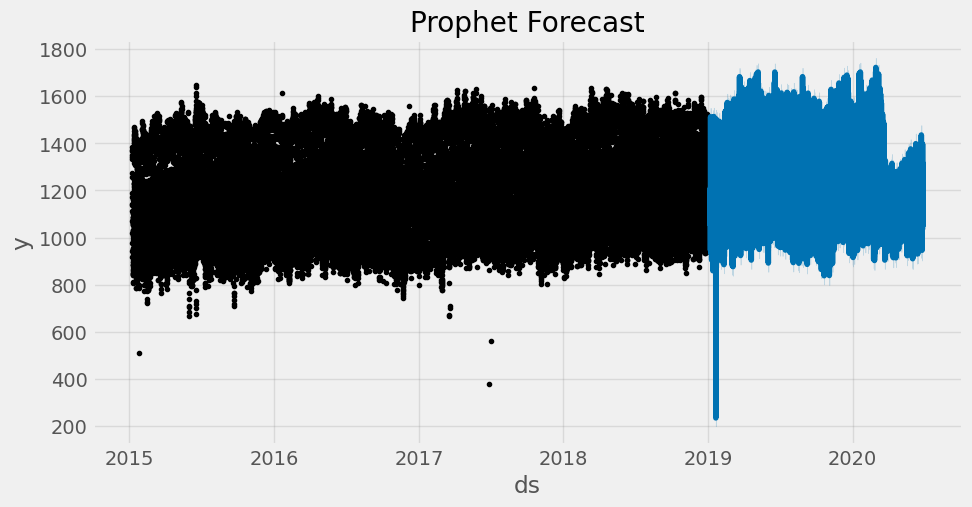

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model_new.plot(df_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

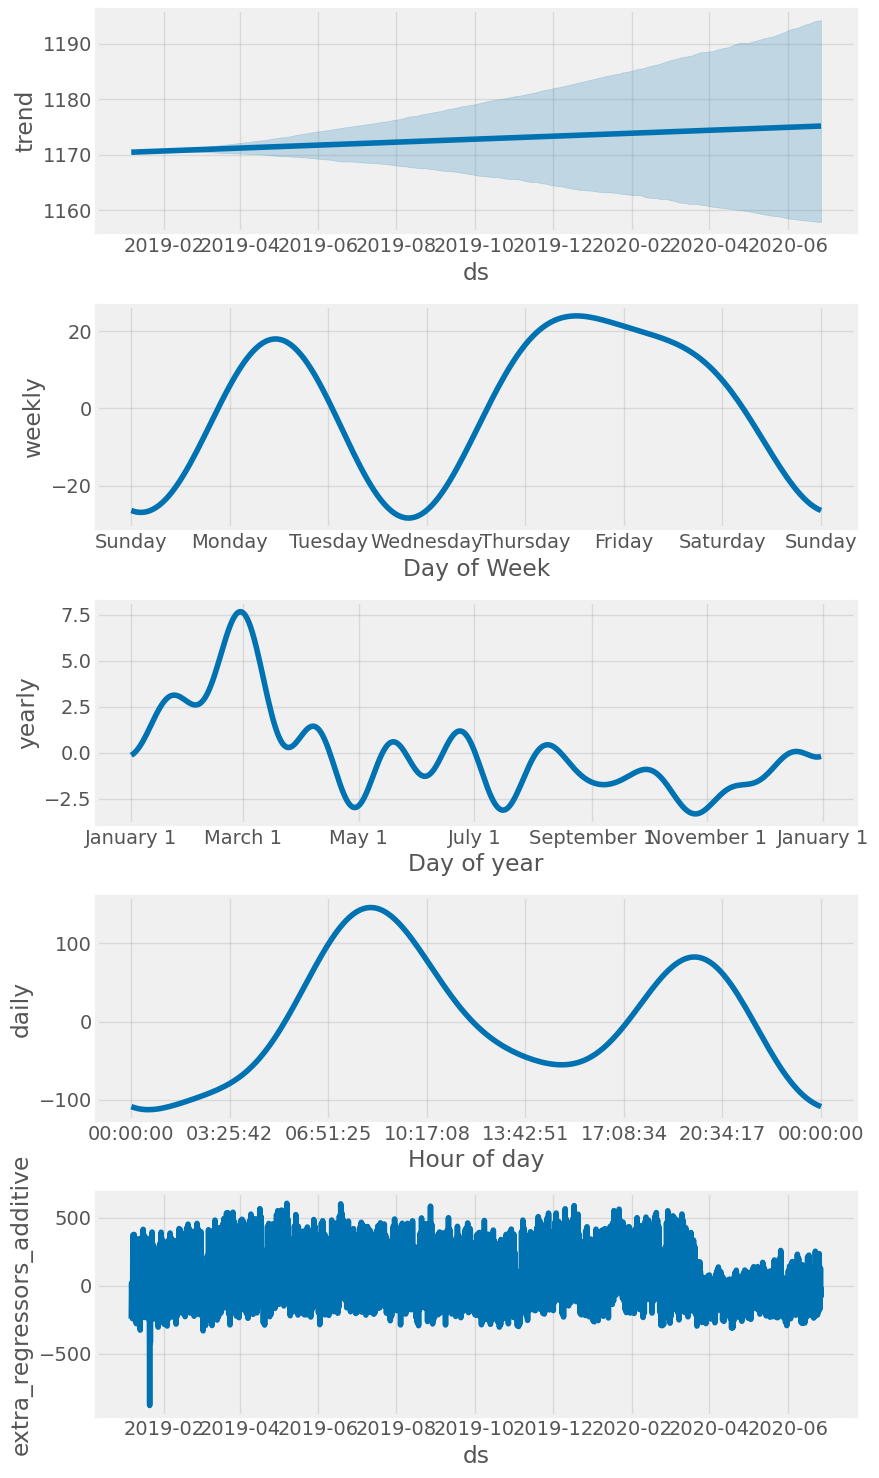

In [ ]:
fig = model_new.plot_components(df_test_fcst)

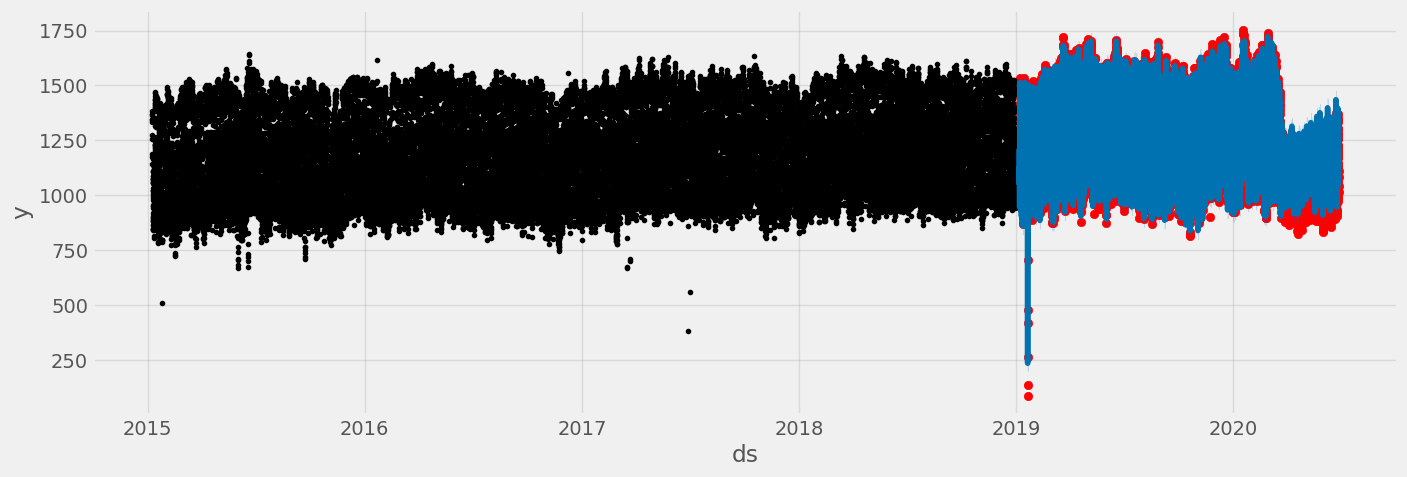

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test_df.index, test_df['nat_demand'], color='r')
fig = model_new.plot(df_test_fcst, ax=ax)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

In [ ]:
len(df_test_fcst)

12905

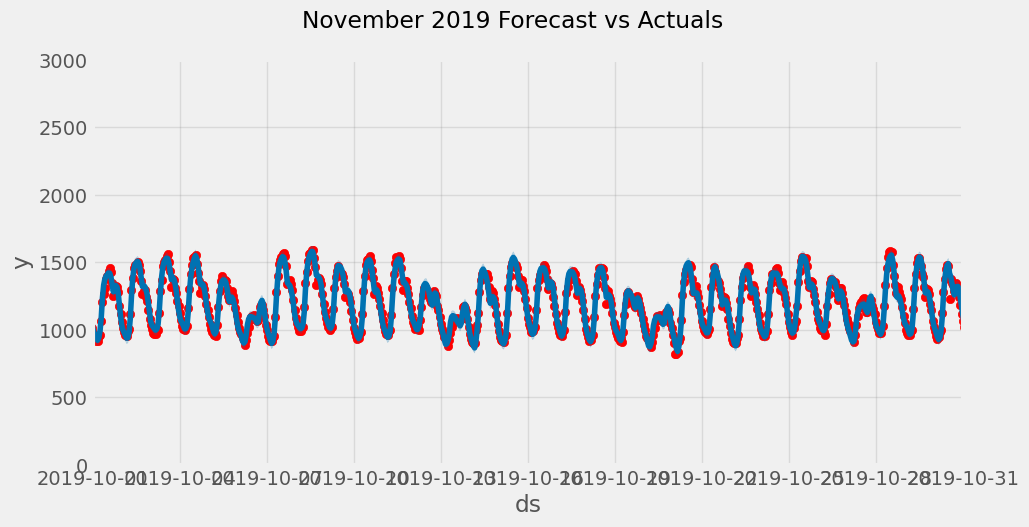

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(test_df.index, test_df['nat_demand'], color='r')
fig = model_new.plot(df_test_fcst, ax=ax)
ax.set_xbound(lower=pd.to_datetime('10-01-2019'), upper=pd.to_datetime('10-31-2019'))
ax.set_ylim(0, 3000)
plot = plt.suptitle('November 2019 Forecast vs Actuals')

errors


In [ ]:
date= test_df.index.copy()
y_true=test_df['nat_demand'].values
y_pred=df_test_fcst['yhat'].values
y_true.size

12905

In [ ]:
y_pred.size

12905

In [ ]:
array1 = y_true
array2 = y_pred
array3 = date

# Create a DataFrame by merging the arrays
data = {'Date':date,'Actual': array1, 'Prophet_Prediction': array2}
df_prophet_prediction = pd.DataFrame(data)

In [ ]:
print("Max: ",max(df_prophet_prediction["Prophet_Prediction"]))
print("Mean: ",mean(df_prophet_prediction["Prophet_Prediction"]))
print("Min: ",min(df_prophet_prediction["Prophet_Prediction"]))

Max:  1721.5714948973896
Mean:  1231.799436633253
Min:  235.0016875981247


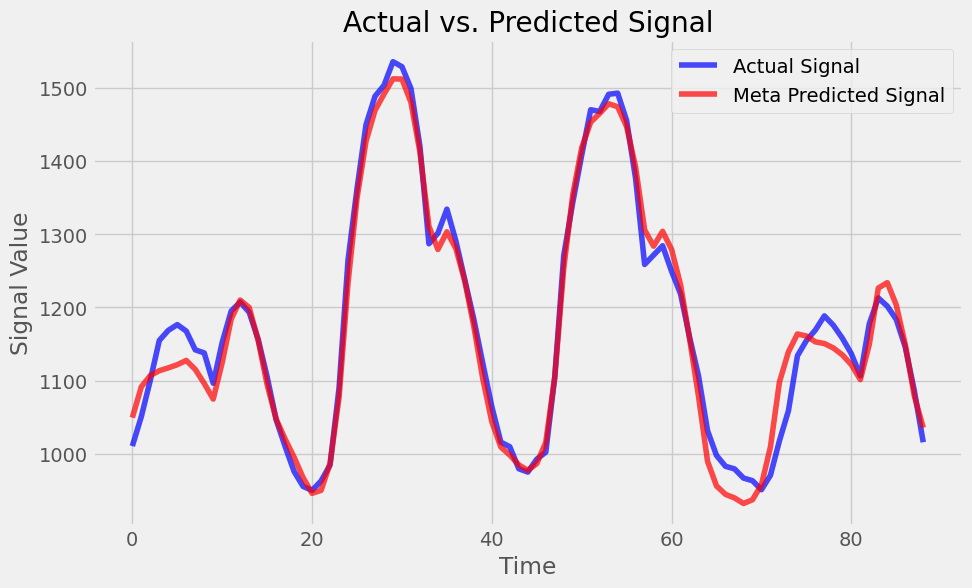

In [ ]:
y_test_pp= df_prophet_prediction.loc[df_prophet_prediction.Date<='2019-01-10' , 'Actual']
predictions_pp= df_prophet_prediction.loc[df_prophet_prediction.Date<='2019-01-10', 'Prophet_Prediction']
timestamps = range(len(y_test_pp))

plt.figure(figsize=(10, 6))
plt.plot(timestamps, y_test_pp, label='Actual Signal', color='blue', alpha = 0.7)
plt.plot(timestamps, predictions_pp, label='Meta Predicted Signal', color='red', alpha = 0.7)

plt.xlabel('Time')
plt.ylabel('Signal Value')
plt.title('Actual vs. Predicted Signal')
plt.legend()
plt.savefig('Predictions')
plt.show()

In [ ]:
df_prophet_prediction.to_csv('predictions_Prophet.csv')

In [ ]:
y_test=y_true
predictions= y_pred

In [ ]:
rmse_test = mean_squared_error(y_test, predictions, squared=False)
mae_test = mean_absolute_error(y_test, predictions)
r2_test = r2_score(y_test, predictions)
explained_variance = explained_variance_score(y_test, predictions)
max_err = max_error(y_test, predictions)
poisson_deviance = mean_poisson_deviance(y_test, predictions)
gamma_deviance = mean_gamma_deviance(y_test, predictions)
tweedie_deviance = mean_tweedie_deviance(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
print(f"RMSE on test data: {rmse_test}")
print(f"MAE on test data: {mae_test}")
print("Mean Absolute Percentage Error:", mape)
print(f"R-squared on test data: {r2_test}")
print(f"Explained Variance on test data: {explained_variance}")
print(f"Max Error on test data: {max_err}")
print(f"Mean Poisson Deviance on test data: {poisson_deviance}")
print(f"Mean Gamma Deviance on test data: {gamma_deviance}")
print(f"Mean Tweedie Deviance on test data: {tweedie_deviance}")

RMSE on test data: 42.02702432181482
MAE on test data: 30.151410213398183
Mean Absolute Percentage Error: 0.026785404716124304
R-squared on test data: 0.9500862143939963
Explained Variance on test data: 0.9540528557718813
Max Error on test data: 622.4605420040609
Mean Poisson Deviance on test data: 1.6294120359258406
Mean Gamma Deviance on test data: 0.0017201426171429347
Mean Tweedie Deviance on test data: 1766.2707733464142


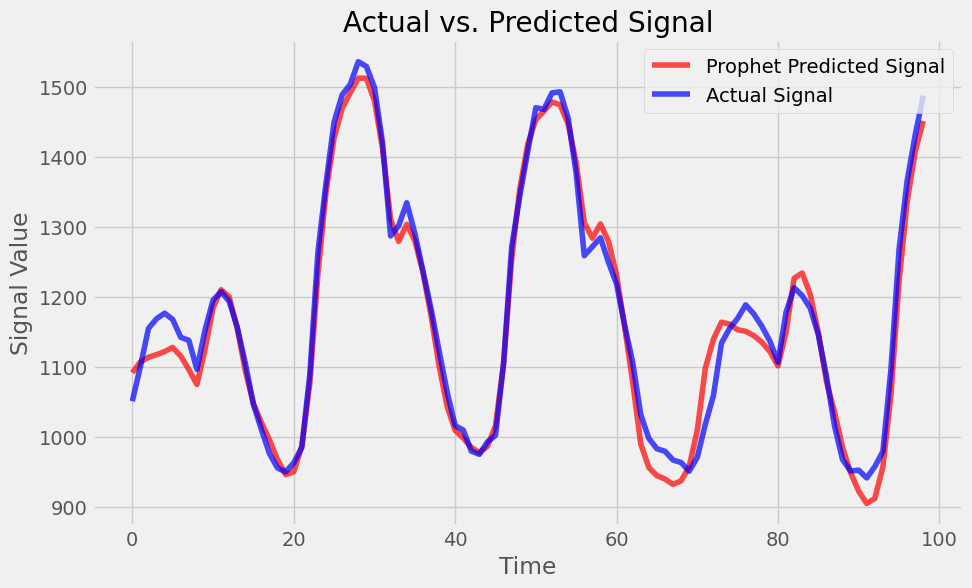

In [ ]:
y_gg= y_test[1:100]
prophet= y_pred[1:100]
timestamps = range(len(y_gg))

plt.figure(figsize=(10, 6))

plt.plot(timestamps, prophet, label='Prophet Predicted Signal', color='red', alpha = 0.7)
plt.plot(timestamps, y_gg, label='Actual Signal', color='blue', alpha = 0.7)
#plt.plot(timestamps, predictions, label='Meta Predicted Signal', color='red', alpha = 0.7)
plt.xlabel('Time')
plt.ylabel('Signal Value')
plt.title('Actual vs. Predicted Signal')
plt.legend()
plt.savefig('Prophet Predictions')
plt.show()

In [ ]:
for columns in train_df.columns:
  print(columns,':float')

nat_demand :float
T2M_toc :float
QV2M_toc :float
TQL_toc :float
W2M_toc :float
T2M_san :float
QV2M_san :float
TQL_san :float
W2M_san :float
T2M_dav :float
QV2M_dav :float
TQL_dav :float
W2M_dav :float
Holiday_ID :float
holiday :float
school :float
nat_demand_lag_12 :float
nat_demand_ma_mean12 :float
nat_demand_std_std12 :float
nat_demand_ewm_std12 :float
nat_demand_ewm_mean12 :float
nat_demand_lag_24 :float
nat_demand_ma_mean24 :float
nat_demand_std_std24 :float
nat_demand_ewm_std24 :float
nat_demand_ewm_mean24 :float
nat_demand_lag_128 :float
nat_demand_ma_mean128 :float
nat_demand_std_std128 :float
nat_demand_ewm_std128 :float
nat_demand_ewm_mean128 :float
T2M_toc_lag_12 :float
T2M_toc_ma_mean12 :float
T2M_toc_std_std12 :float
T2M_toc_ewm_std12 :float
T2M_toc_ewm_mean12 :float
T2M_toc_min_max12 :float
T2M_toc_median12 :float
T2M_toc_skew12 :float
T2M_toc_kurt12 :float
T2M_toc_p5012 :float
T2M_toc_lag_24 :float
T2M_toc_ma_mean24 :float
T2M_toc_std_std24 :float
T2M_toc_ewm_std24 :float